<a href="https://colab.research.google.com/github/egyvedriyanto78/Forecasting-Experiment/blob/main/GoldOnlyExpLSTM001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting Experiment with Gold Closing Price Only using LSTM

## Data Collection

In [1]:
# Install yfinance package jika belum diinstall
!pip install yfinance

In [2]:
# Import library yang dibutuhkan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Library untuk LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Fetch data GOLD (XAU/USD) dari Yahoo Finance
import yfinance as yf

In [3]:
# Definisikan rentang waktu data
start_date = "2013-05-03"
end_date = "2022-12-31"

# Ambil data GOLD (harga emas) dari Yahoo Finance
gold_data = yf.download("GC=F", start=start_date, end=end_date)[['Close']].rename(columns={'Close': 'GOLD'})

# Ubah index ke kolom tanggal
gold_data.index = pd.to_datetime(gold_data.index)
gold_data = gold_data.reset_index()
gold_data.columns = ['Date', 'GOLD']

# Hapus informasi timezone pada tanggal
gold_data['Date'] = gold_data['Date'].dt.tz_localize(None)

# Tampilkan data GOLD
print(gold_data.head())

[*********************100%***********************]  1 of 1 completed

        Date         GOLD
0 2013-05-03  1464.300049
1 2013-05-06  1468.099976
2 2013-05-07  1449.000000
3 2013-05-08  1473.900024
4 2013-05-09  1468.800049


## Data Visualization

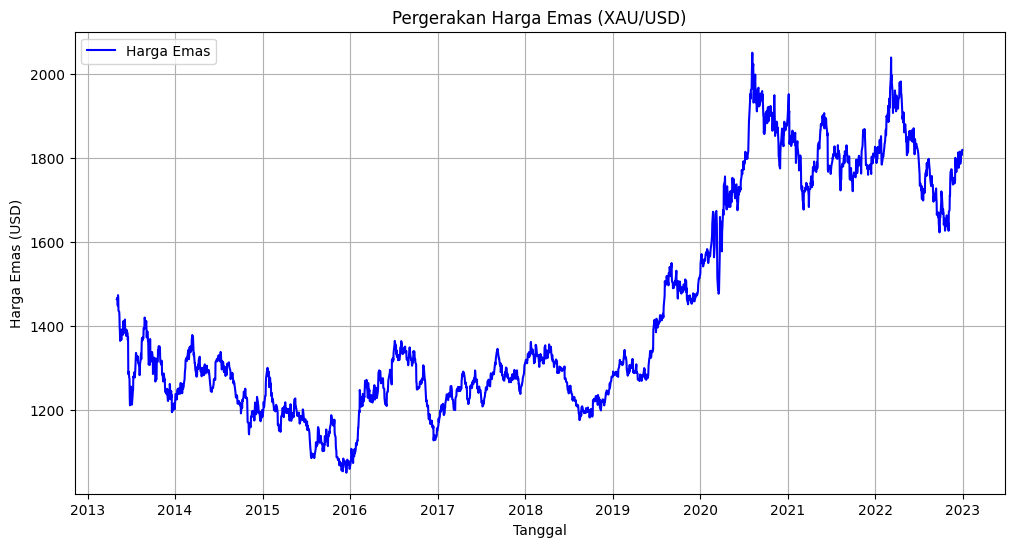

In [4]:
# Plot harga emas dari awal hingga akhir
plt.figure(figsize=(12, 6))
plt.plot(gold_data['Date'], gold_data['GOLD'], color='blue', label='Harga Emas')
plt.title('Pergerakan Harga Emas (XAU/USD)')
plt.xlabel('Tanggal')
plt.ylabel('Harga Emas (USD)')
plt.legend()
plt.grid()
plt.show()

## Data Preprocessing

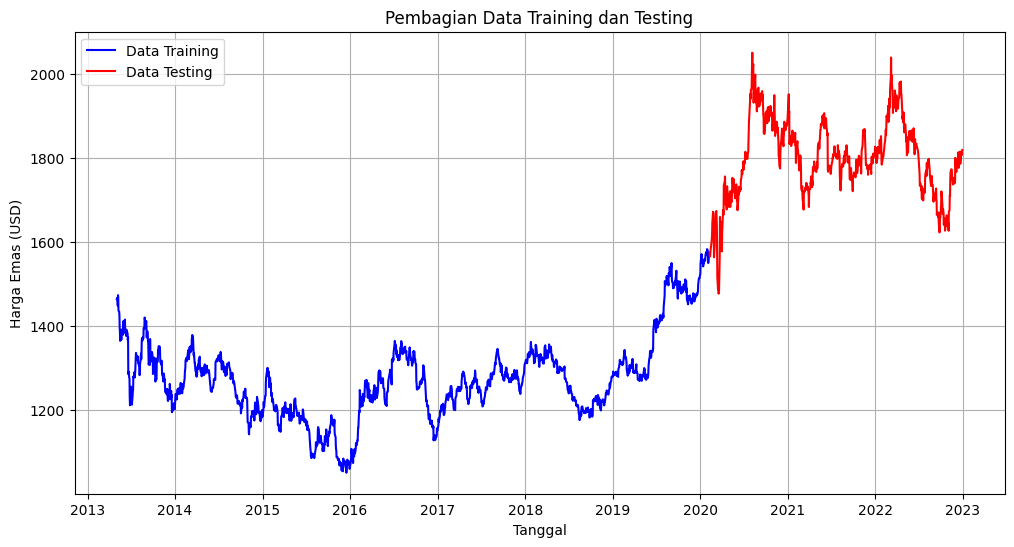

In [5]:
# Normalisasi data agar LSTM dapat belajar lebih baik
scaler = MinMaxScaler(feature_range=(0, 1))
gold_data['Scaled'] = scaler.fit_transform(gold_data[['GOLD']])

# Splitting manual: 70% untuk training, 30% untuk testing
train_size = int(len(gold_data) * 0.7)
train_data = gold_data[:train_size]
test_data = gold_data[train_size:]

# Visualisasi data train dan test
plt.figure(figsize=(12, 6))
plt.plot(train_data['Date'], train_data['GOLD'], color='blue', label='Data Training')
plt.plot(test_data['Date'], test_data['GOLD'], color='red', label='Data Testing')
plt.title('Pembagian Data Training dan Testing')
plt.xlabel('Tanggal')
plt.ylabel('Harga Emas (USD)')
plt.legend()
plt.grid()
plt.show()

In [6]:
# Fungsi untuk membentuk data ke format LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Gunakan kolom 'Scaled' untuk pelatihan
time_step = 60  # Menggunakan 60 hari terakhir untuk memprediksi
X_train, y_train = create_dataset(train_data[['Scaled']].values, time_step)
X_test, y_test = create_dataset(test_data[['Scaled']].values, time_step)

# Reshape ke [samples, time steps, features] untuk input LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

## Modeling

In [7]:
# Definisikan model LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))  # Untuk mencegah overfitting
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Latih model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - loss: 0.0198 - val_loss: 0.0032
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 9.6790e-04 - val_loss: 0.0015
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 8.3427e-04 - val_loss: 0.0014
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 8.3253e-04 - val_loss: 0.0014
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 8.3007e-04 - val_loss: 0.0011
Epoch 9/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 7.8765e-04 - val_loss: 0.0031
Epoch 10/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 7.9097e-04 - val_loss: 0.0010
Epoch 11/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 7.2100e-04 - val_loss: 0.0010
Epoch 12/50
52/52 ━━━━━━━━━━━━━━━━━

## Model Evaluation

In [11]:
# Prediksi pada data training dan testing
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Mengembalikan data prediksi ke skala aslinya
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Hitung metrik evaluasi
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))
train_mae = mean_absolute_error(y_train_actual, train_predict)
test_mae = mean_absolute_error(y_test_actual, test_predict)

# Hitung akurasi (MAPE)
train_mape = np.mean(np.abs((y_train_actual - train_predict) / y_train_actual)) * 100
test_mape = np.mean(np.abs((y_test_actual - test_predict) / y_test_actual)) * 100

# Tampilkan hasil evaluasi dalam tabel
eval_results = pd.DataFrame({
    "Dataset": ["Training", "Testing"],
    "RMSE": [train_rmse, test_rmse],
    "MAE": [train_mae, test_mae],
    "MAPE": [train_mape, test_mape]
})

print(eval_results)

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    Dataset       RMSE        MAE      MAPE
0  Training  14.820408  11.534108  0.899088
1   Testing  28.947644  24.281771  1.331698


## Model Prediction

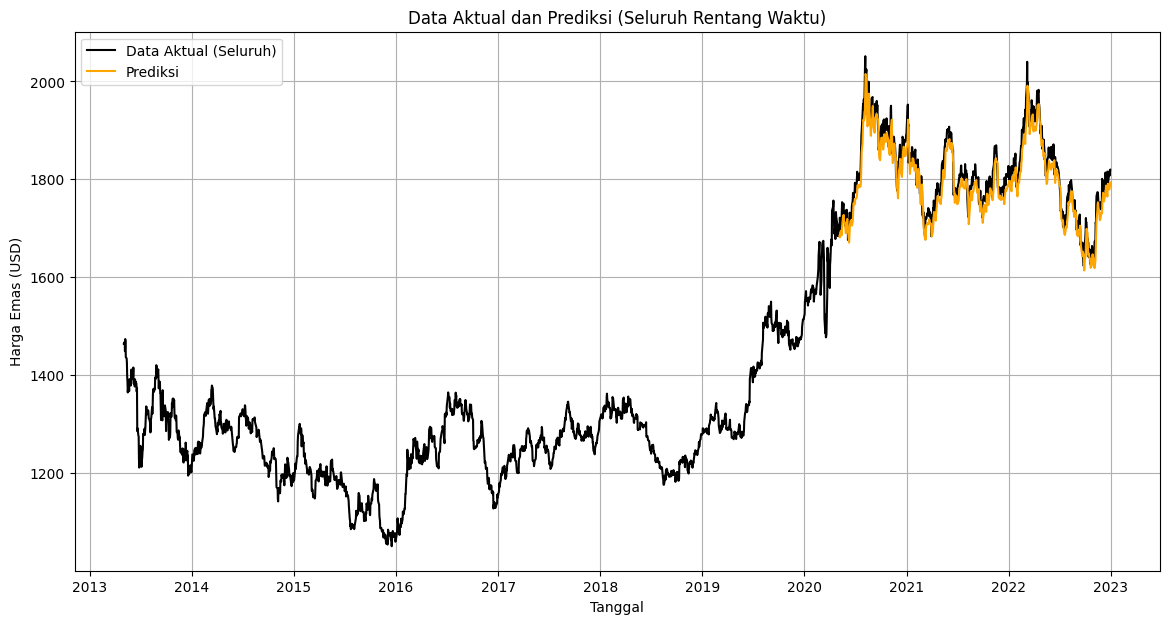

In [19]:
# Gabungkan data aktual dan prediksi untuk seluruh rentang waktu
full_data = gold_data.copy()
full_data['Predicted'] = np.nan

# Isi prediksi hanya untuk 30% terakhir
full_data.loc[len(full_data) - len(test_predict):, 'Predicted'] = test_predict.flatten()

# Plot seluruh data dengan prediksi
plt.figure(figsize=(14, 7))
plt.plot(full_data['Date'], full_data['GOLD'], label='Data Aktual (Seluruh)', color='black')
plt.plot(full_data['Date'], full_data['Predicted'], label='Prediksi', color='orange')

plt.title('Data Aktual dan Prediksi (Seluruh Rentang Waktu)')
plt.xlabel('Tanggal')
plt.ylabel('Harga Emas (USD)')
plt.legend()
plt.grid()
plt.show()

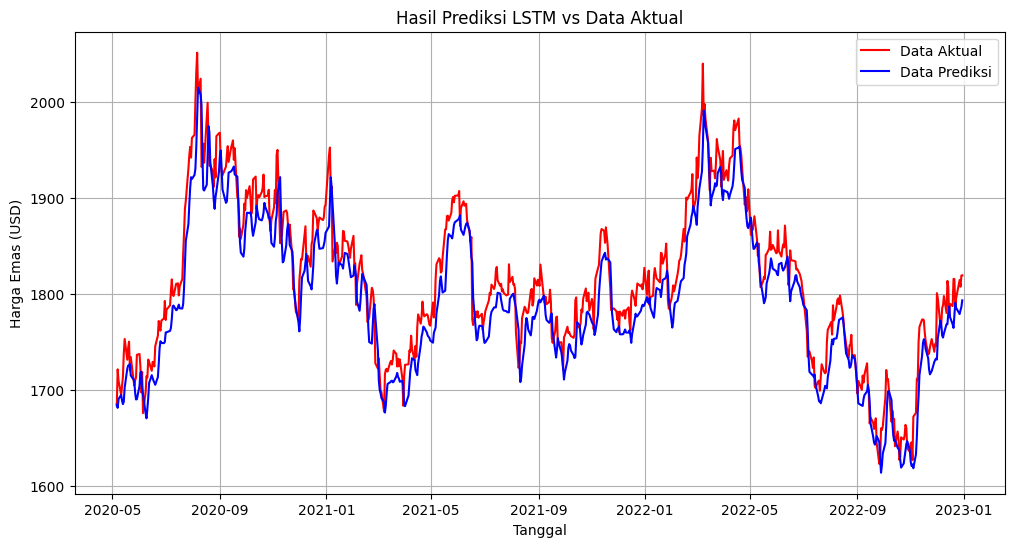

In [9]:
# Visualisasi hasil prediksi
plt.figure(figsize=(12, 6))
plt.plot(test_data['Date'][time_step:], y_test_actual, color='red', label='Data Aktual')
plt.plot(test_data['Date'][time_step:], test_predict, color='blue', label='Data Prediksi')
plt.title('Hasil Prediksi LSTM vs Data Aktual')
plt.xlabel('Tanggal')
plt.ylabel('Harga Emas (USD)')
plt.legend()
plt.grid()
plt.show()